# `007` Batch normalization

Requirements: 006 Pytorch

Since neural networks are universal approximators, stacking many layers can help us model complex functions (this is why deep learning is called deep). However, as we stack more layers, we can run into problems with optimization. One of the main issues is that the weights in the initial layers can create very large or very small butterfly effects in the later layers. This can make training very slow or even impossible. Very large effects can cause the gradients to explode, while very small effects can cause the gradients to vanish. Hence, when doing gradient descent and multiplying the gradient by the learning rate, the weights can become very large or very small.

Let see this problem in action with the MNIST problem from the Pytorch notebook and using a deep network.

In [1]:
import torch
import torchvision

# load the MNIST dataset
train = torchvision.datasets.MNIST(root='data', download=True)
test = torchvision.datasets.MNIST(root='data', download=True, train=False)
x = train.data.view(-1, 28 * 28).float()
xt = test.data.view(-1, 28 * 28).float()
y = torch.nn.functional.one_hot(train.targets).float()
yt = torch.nn.functional.one_hot(test.targets).float()

# initialize a deep neural network
model = [torch.nn.Linear(28 * 28, 64), torch.nn.ReLU()]
for _ in range(16):
	model.extend([
		torch.nn.Linear(64, 64),
		torch.nn.ReLU()
	])
model.append(torch.nn.Linear(64, 10))
model = torch.nn.Sequential(*model)

# train the model
print(f'Training model with {sum(p.numel() for p in model.parameters())} parameters')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for i in range(1000):
	ix = torch.randint(0, x.shape[0], (32,))
	xb, yb = x[ix], y[ix]
	logits = model(xb)
	loss = torch.nn.functional.cross_entropy(logits, yb.argmax(dim=1))
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()
	if i % 500 == 0: print(f'Iteration {i}, loss: {loss.item()}')
accuracy = (model(xt).argmax(dim=1) == yt.argmax(dim=1)).float().mean().item()
print(f'Accuracy on the test set: {100 * accuracy:.2f}%')

Training model with 117450 parameters
Iteration 0, loss: 2.3028974533081055
Iteration 500, loss: 2.3141260147094727
Accuracy on the test set: 11.35%


Classification accuracy dropped to $11\%$, which is barely better than random guessing. Let's examine the gradients of the first layer.

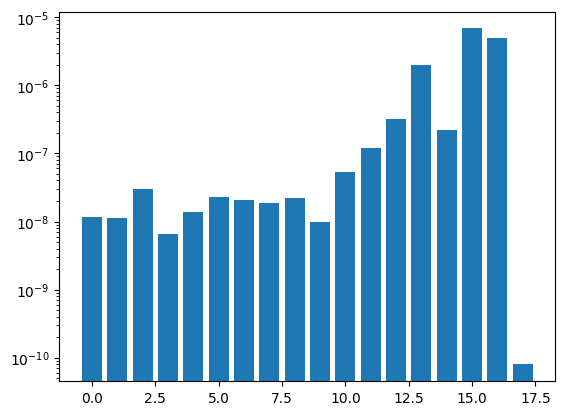

In [2]:
from matplotlib import pyplot as plt

gradients = []
for layer in model:
	if isinstance(layer, torch.nn.Linear):
		gradients.append(layer.weight.grad.mean().abs().item())
plt.bar(range(len(gradients)), gradients)
plt.yscale('log')

We can't see that the gradients are extremely small, which is why the weights are not updating. To solve this vanishing gradients problem we will define a normalization layer that will normalize the input to have zero mean and unit variance. This will help the gradients to be more stable and not vanish. We'll have to be careful, because if we use a full batch for normalizing during training, when we use the model for inference over a single example, the normalization will be different. To solve this, we will use the running mean and variance of the training data to normalize the input during inference.

In [3]:
class BatchNorm(torch.nn.Module):
	def __init__(self, size):
		super().__init__()
		self.size = size
		self.gamma = torch.nn.Parameter(torch.ones(size))
		self.beta = torch.nn.Parameter(torch.zeros(size))
		self.register_buffer('running_mean', torch.zeros(size))
		self.register_buffer('running_var', torch.ones(size))

	def forward(self, x):
		if self.training:
			mean = x.mean(dim=0)
			var = x.var(dim=0)
			self.running_mean = 0.9 * self.running_mean + 0.1 * mean
			self.running_var = 0.9 * self.running_var + 0.1 * var
		else:
			mean = self.running_mean
			var = self.running_var
		x = (x - mean) / (var + 1e-5).sqrt()
		x = x * self.gamma + self.beta
		return x

Let's try to understand what's going on here:
* We define a new class `BatchNorm` that inherits from `torch.nn.Module`, which is the base class for all neural network modules in PyTorch.
* The constructor of `BatchNorm` takes a single argument `size`, which is the number of features in the input tensor.
* We then define two trainable parameters `gamma` and `beta`, which are used to scale and shift the normalized tensor. By defining tensors in `self`, pytorch automatically registers them as learnable parameters of the module.
* We also define two buffers `running_mean` and `running_var`, which are used to keep track of the running mean and variance of the input tensor. In contrast to parameters, **buffers** are not updated by the optimizer during training.
* If the module is in training mode, we compute the mean and variance of the input tensor along the batch dimension using the `mean` and `var` methods. We then update the running mean and variance using an exponential moving average.
* The normalized tensor is then scaled by `gamma` and shifted by `beta` to obtain the final output.

In [4]:
# initialize a deep neural network
model = [torch.nn.Linear(28 * 28, 64), torch.nn.ReLU()]
for _ in range(16):
	model.extend([
		torch.nn.Linear(64, 64),
		BatchNorm(64),  # <-------------- batch norm
		torch.nn.ReLU()
	])
model.append(torch.nn.Linear(64, 10))
model = torch.nn.Sequential(*model)

# train the model
print(f'Training model with {sum(p.numel() for p in model.parameters())} parameters')
model.train()  # <------------------- this is now needed for self.training in BatchNorm to work
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for i in range(1000):
	ix = torch.randint(0, x.shape[0], (32,))
	xb, yb = x[ix], y[ix]
	logits = model(xb)
	loss = torch.nn.functional.cross_entropy(logits, yb.argmax(dim=1))
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()
	if i % 500 == 0: print(f'Iteration {i}, loss: {loss.item()}')
model.eval()  # <------------------- this is now needed for self.training in BatchNorm to work
accuracy = (model(xt).argmax(dim=1) == yt.argmax(dim=1)).float().mean().item()
print(f'Accuracy on the test set: {100 * accuracy:.2f}%')

Training model with 119498 parameters
Iteration 0, loss: 2.3788464069366455
Iteration 500, loss: 0.9425084590911865
Accuracy on the test set: 89.69%


This is much better than before! Why did we get such a big improvement? Let's plot our gradients again:

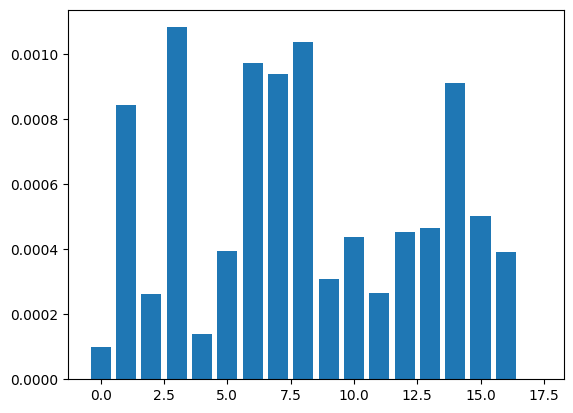

In [5]:
gradients = []
for layer in model:
	if isinstance(layer, torch.nn.Linear):
		gradients.append(layer.weight.grad.mean().abs().item())
plt.bar(range(len(gradients)), gradients);

The gradient values are significantly larger than before, which is why the weights are updating. This is because the normalization layer helps the gradients to be more stable and not vanish.

Although batch normalization solves the vanishing gradients problem, it introduces the problem of elements from the same batch being dependent on each other. This dependency makes the model's input features in production different from the input features during training. That problem is called **internal covariate shift**, and it can make the model less robust and can lead to overfitting. More normalization techniques have been proposed to solve this problem.